<h1 style="font-size:30px;">Application: E-Signature</h1> 

In this notebook, we are going to demonstrate how to create a transparent digital signature from a photo that can be then imported into PDF documents. By doing this, we will apply knowledge of the following topics:

* Cropping images
* Changing image color formats
* Thresholding & Masking
* Color tinting
* Creating alpha channels


In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.display import Image
plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.rcParams['image.cmap'] = 'gray'

if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/f8ae3j0nbrflife/AAAy-WwcREtWOGgoEbFLDPANa?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    %cd Applications/
else:
    pass

# 1. Read and Display the Original Handwritten Signature
We are going to load the image in normal mode, which comes in BGR format by default. This is important to note because we will need to convert it to RGB later for display.
### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`imread()`**](https://docs.opencv.org/4.5.2/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56)
[**`imreadModes()`**](https://docs.opencv.org/4.5.2/d8/d6a/group__imgcodecs__flags.html#ga61d9b0126a3e57d9277ac48327799c80)
[**`cvtColor()`**](https://docs.opencv.org/4.5.2/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab)

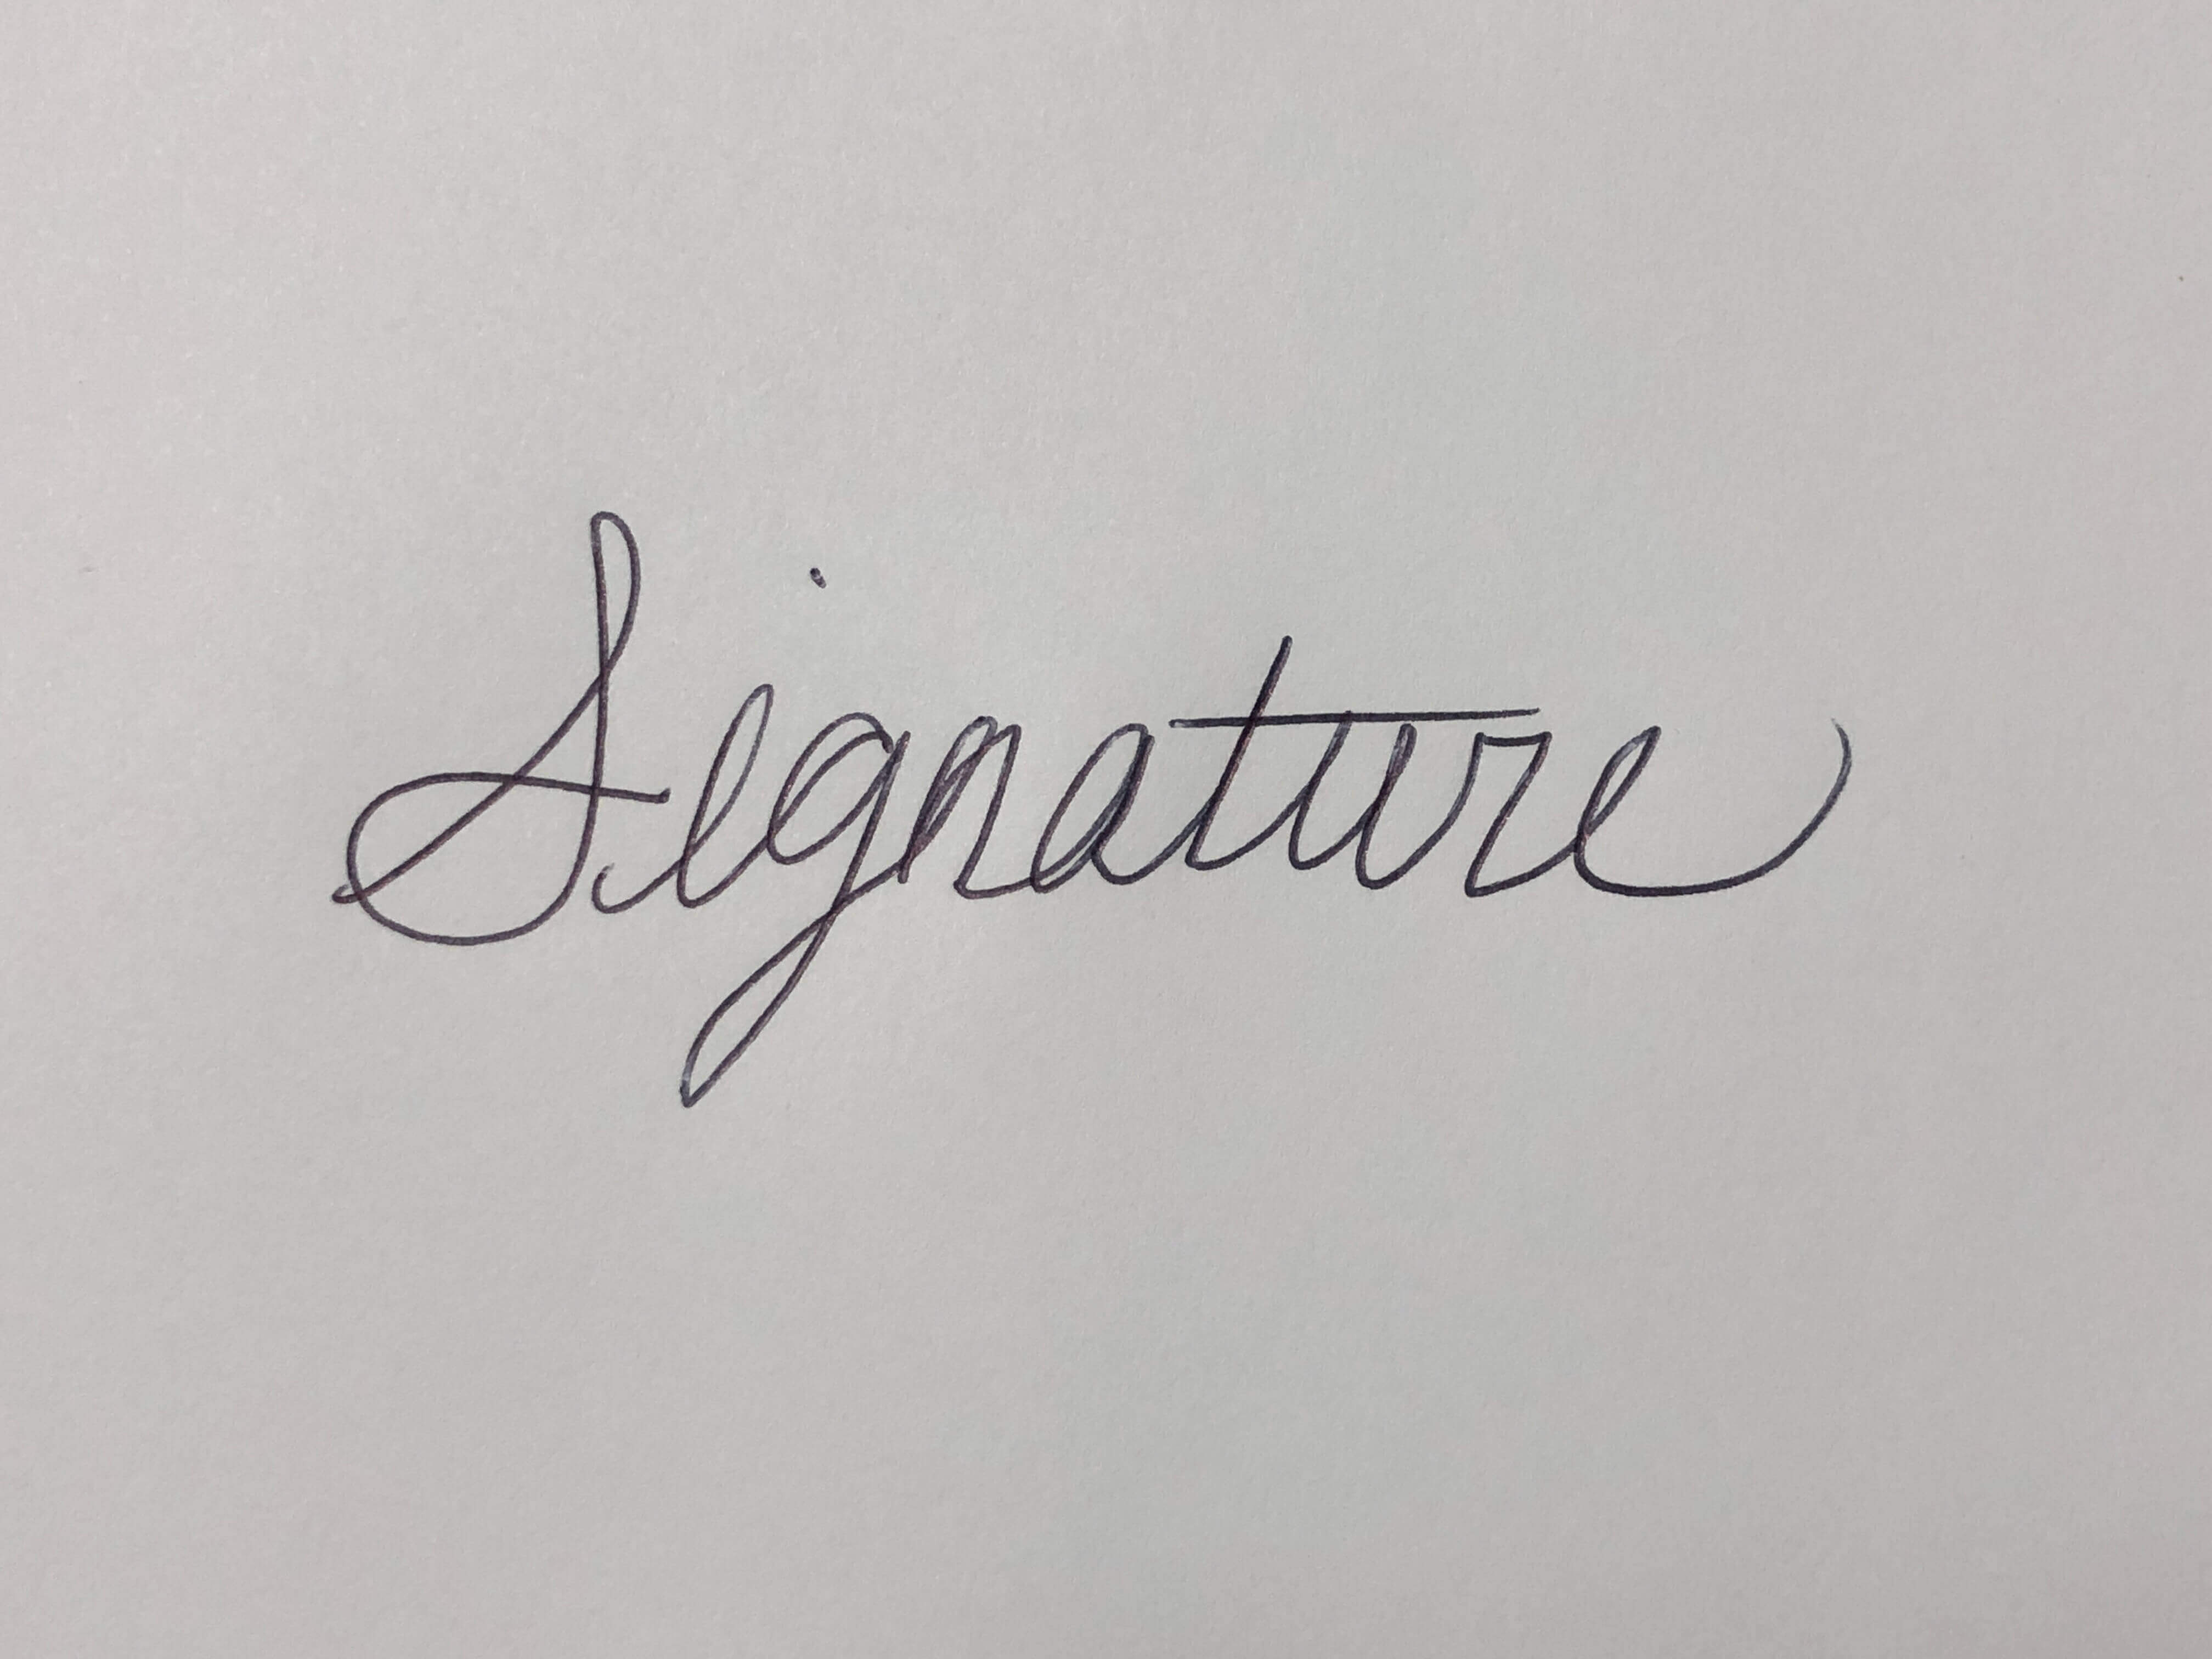

In [2]:
# Read the image.
sig_org = cv2.imread('signature.jpg', cv2.IMREAD_COLOR)

# Display the actual image in the browser.
Image('signature.jpg', width = '400')

# 2. Crop the Signature

### <font style="color:rgb(50,120,230)">Display the image for size<font/>

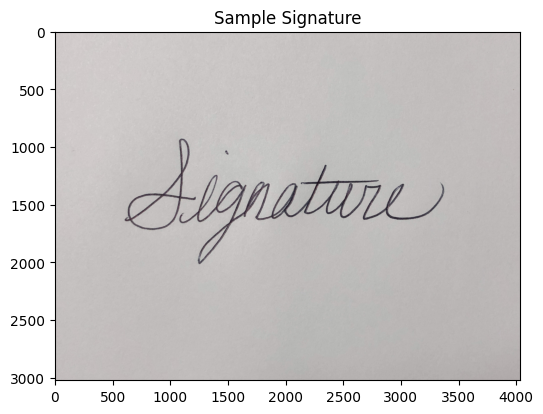

In [3]:
# Display the image using imshow() so we can see the size with axis.
plt.imshow(sig_org[:, :, ::-1])
plt.title('Sample Signature');

### <font style="color:rgb(50,120,230)">Crop the signature<font/>
This step is not technically required in this case. However, if the original image contained artifacts such as shadows or other markings on the paper, then cropping them out can be helpful prior to creating the alpha mask. Removing excess whitespace around the signature also makes it more convenient to work with and transform once brought into a PDF editor.

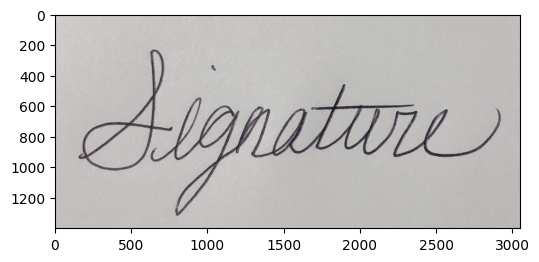

In [4]:
# Crop the signature from the original image.
sig = sig_org[700:2100, 450:3500, :]
plt.imshow(sig[:, :, ::-1]);

# 3.  Convert to Grayscale 
Here, we are converting the image to grayscale using `cvtColor()`. The output is a 1-channel image, which is the first step to creating our alpha (transparency) channel.


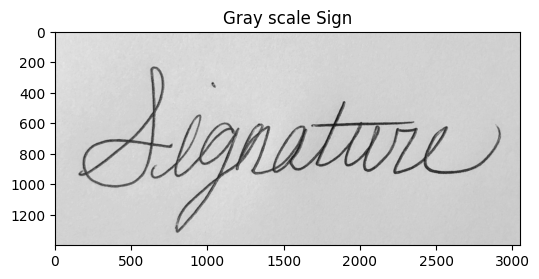

In [5]:
sig_gray = cv2.cvtColor(sig, cv2.COLOR_BGR2GRAY)
plt.imshow(sig_gray)
plt.title('Gray scale Sign');

# 3.  Create an Alpha Mask

Use the **`threshold()`** function to extract the alpha mask. The function applies a fixed-level threshold to each array element. We need to specify a threshold value that is greater than the intensity of the signature and lower than the value of the background. In this case, the specific threshold value is not critical. Many middle tone values will work in the case (120 to 170). The output can directly be used as the alpha channel for the signature, noting that pure block will be transparent, and pure white will be opaque.

<hr   style="border:none; height: 4px; background-color: #D3D3D3 " />

 ### <font style="color:rgb(8,133,37)">Function Syntax </font>
``` python
retval, dst = cv2.threshold(src, thresh, maxval, type[, dst])
```
`retval`: returns true upon success. <br>
`dst`: Is the output image of the same size and depth as `src`.

The function has **4 required arguments**:

1. `src`: input array (multiple-channel, 8-bit or 32-bit floating point).
2. `thresh`: threshold value.
3. `maxval`:	maximum value to use with the **THRESH_BINARY** and **THRESH_BINARY_INV** thresholding types.
4. `type`: thresholding type (see ThresholdTypes).

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`threshold types`**](https://docs.opencv.org/4.5.2/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576)

<hr   style="border:none; height: 4px; background-color: #D3D3D3 " />


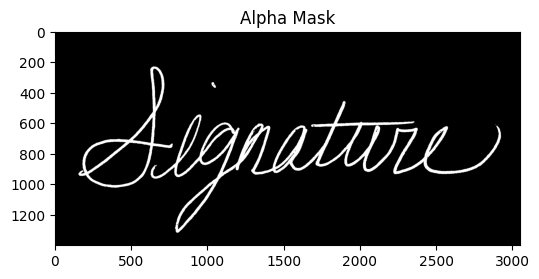

In [6]:
ret, alpha_mask = cv2.threshold(sig_gray, 150, 255, cv2.THRESH_BINARY_INV)
cv2.imwrite('alpha_mask.jpg', alpha_mask)
plt.imshow(alpha_mask)
plt.title('Alpha Mask');

# 3.  Enhance the Color (optional)
This is an optional step in which we will enhance the color of the signature. There are numerous methods that can be used to accomplish this. Here we will use the **`addWeighted()`** function to blend the signature with a saturated color. 

### <font style="color:rgb(50,120,230)">Create a blue mask for blending<font/>

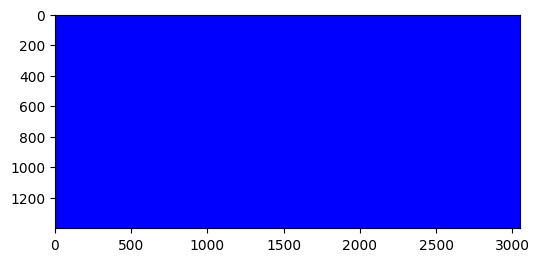

In [7]:
blue_mask = sig.copy()
blue_mask[:, :] = (255, 0, 0)
plt.imshow(blue_mask[:, :, ::-1]);



### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`addWeighted()`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19)

<hr   style="border:none; height: 4px; background-color: #D3D3D3 " />

### <font style="color:rgb(50,120,230)">Blend the signature with the mask<font/>

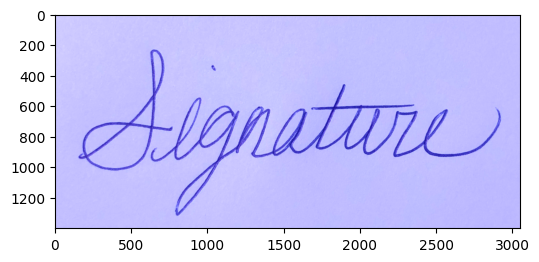

In [8]:
sig_color = cv2.addWeighted(sig, 1, blue_mask, 0.5, 0)
plt.imshow(sig_color[:, :, ::-1]);

# 4. Add the Alpha Mask as the 4th Channel to the Image
The alpha channel contains the transparency information. The pixel intensity ranges from 0-255. 0 represents full transparency and 255 represents full opacity. Any value in between represents partial transparency. To add the alpha channel, we need to split the channels of the original color image, add a 4th channel, and merge all four channels as a single (multi-channel) array.
### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`split`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#ga0547c7fed86152d7e9d0096029c8518a)
[**`merge`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#ga7d7b4d6c6ee504b30a20b1680029c7b4)

### <font style="color:rgb(50,120,230)">Split the color channels from the color image<font/>

In [10]:
# Split the color channels from the color image.
b, g, r = cv2.split(sig)
print(b.shape)
print(g.shape)
print(r.shape)

(1400, 3050)
(1400, 3050)
(1400, 3050)


### <font style="color:rgb(50,120,230)">Add the Alpha mask as a 4th channel and merge the channels<font/>

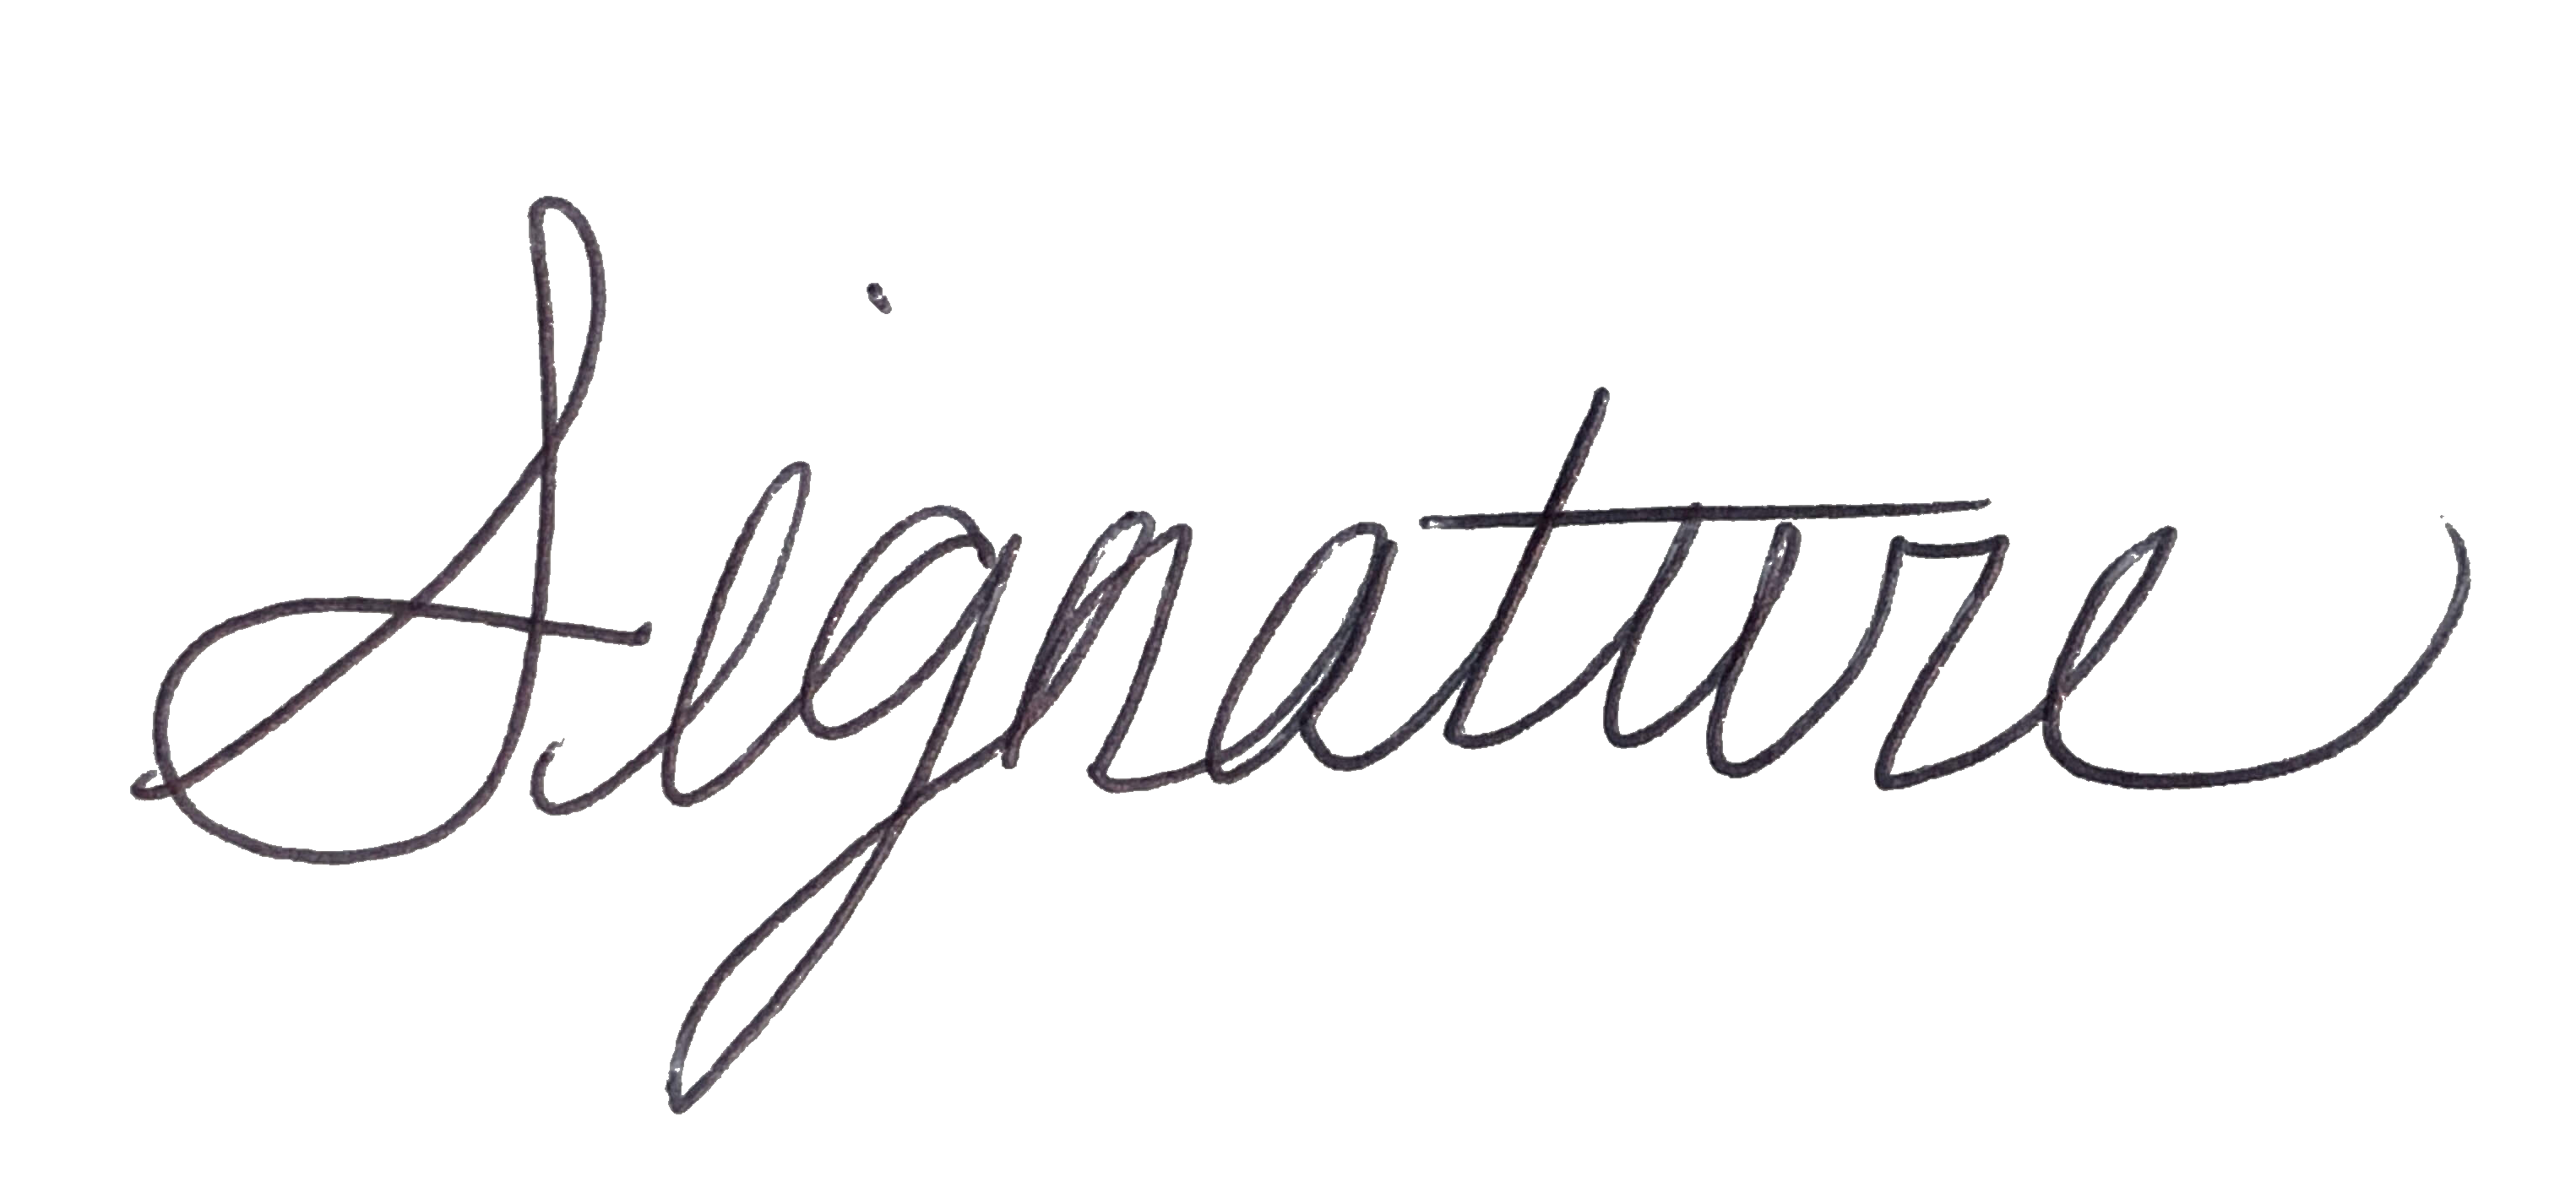

In [11]:
# Create a list of the four arrays with the alpha channel as the 4th member. These are four separate 2D arrays.
new = [b, g, r, alpha_mask]

# Use the merge() function to create a single, multi-channel array.
png = cv2.merge(new, 4)

# Save the transparent signature a PNG file to retain the alpha channel.
cv2.imwrite('extracted_sig.png', png)

# Display the actual image in the browser.
Image('extracted_sig.png', width = '400')

# 5. Import the Digital Signature into a PDF Document
PDF documents allow you to import digital signatures. Let's take a look at the final result after removing the background.

![Signed-Document](https://opencv.org/wp-content/uploads/2021/08/c0-m2-Signed-Document.png)